# Exploring census blocks & joining to 911 data
911 calls file is [here](https://app.box.com/file/911911135646)

Census blocks can be downloaded from [here](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) directly, or from box [here](https://bloombergdotorg.box.com/s/mwv5tbz4l9de6vhxps5vhn71bv42j8ik)

Prose notes can be found [here](

## General Census block notes
These are hierarchical, and pretty granular in populated areas.

The hierarchy looks like this, where each X is and integer: 
XX|XXX|XXXXXX|XXXX

To avoid counting Xs, the lengths are: 
2|3|6|4

With meanings: 
State | county | tract | block

## 911 calls and census blocks
The 911 calls dataset has a column block_id with len(block_id)==15

The calls dataset does have null block ids (~3% in the small sample I checked). For each of them, it does have a lat/long, so we can probably figure it out

## Census block shp files
Downloading Michigan from the ‘Block Groups’ dropdown from the census gives you a shape file with columns GEOID and NAME. GEOID represents the first 11 character, and NAME the block id.








In [13]:
import geopandas as gpd
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd

# Only read in the columns we want
COLS_911 = [
    "calldescription",
    "call_timestamp",
    "block_id",
    "category",
    "officerinitiated",
    "priority",
    "oid",
]

In [39]:
tract = gpd.read_file('/Users/ahakso/Downloads/cb_2018_26_tract_500k/cb_2018_26_tract_500k.shp')

In [49]:
tract.head().drop(columns=['geometry']).astype(str).iloc[0,:].apply(len)

STATEFP      2
COUNTYFP     3
TRACTCE      6
AFFGEOID    20
GEOID       11
NAME         4
LSAD         2
ALAND        7
AWATER       1
Name: 0, dtype: int64

In [ ]:

block = gpd.read_file('./census_blocks_from_census/cb_2018_26_bg_500k.shp')

In [80]:
block.block_id.head(1).astype(float).astype(pd.Int64Dtype())

0    261251813001813
Name: block_id, dtype: Int64

In [89]:
block

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,block_id
0,26,125,181300,1400000US26125181300,26125181300,1813,CT,2610265,0,"POLYGON ((-83.10576 42.50476, -83.09680 42.504...",261251813001813
1,26,163,594500,1400000US26163594500,26163594500,5945,CT,2129984,0,"POLYGON ((-83.21621 42.12865, -83.21560 42.128...",261635945005945
2,26,163,597000,1400000US26163597000,26163597000,5970,CT,9554187,1867845,"POLYGON ((-83.22940 42.08143, -83.22525 42.086...",261635970005970
3,26,163,985200,1400000US26163985200,26163985200,9852,CT,2436035,0,"POLYGON ((-82.97931 42.38890, -82.97603 42.389...",261639852009852
4,26,165,380600,1400000US26165380600,26165380600,3806,CT,4968219,0,"POLYGON ((-85.40649 44.26698, -85.39652 44.266...",261653806003806
...,...,...,...,...,...,...,...,...,...,...,...
2767,26,049,013600,1400000US26049013600,26049013600,136,CT,1410481,34574,"POLYGON ((-83.69382 43.04312, -83.68735 43.043...",26049013600136
2768,26,163,584100,1400000US26163584100,26163584100,5841,CT,3281358,442,"POLYGON ((-83.25428 42.22690, -83.24802 42.227...",261635841005841
2769,26,111,290900,1400000US26111290900,26111290900,2909,CT,6522183,4587,"POLYGON ((-84.24713 43.65593, -84.22713 43.655...",261112909002909
2770,26,099,263900,1400000US26099263900,26099263900,2639,CT,1412635,0,"POLYGON ((-83.02672 42.46309, -83.01860 42.463...",260992639002639


In [96]:
call = (
    csv_with_x_y_to_gpd(
        "calls_for_service_from_jimmy.csv",
        read_csv_args={"nrows": 1000, "usecols": COLS_911 + ["longitude", "latitude"]},
    )
#     want to use ints, but default type does not handle nulls. May factorize later
    .astype({"call_timestamp": "datetime64", "block_id": pd.Int64Dtype()})
    .loc[:, COLS_911 + ["geometry"]]
)

block = (
    gpd.read_file("./census_blocks_from_census/cb_2018_26_tract_500k.shp")
#     full block id is concatenation of geoid and name. Remove optional `.` delimiter
    .assign(block_id=lambda x: (x.GEOID + x.NAME).str.replace('.','',regex=False))
#     Can't go to Int64Dtype from string, convert to int first
    .astype({"block_id": int})
#     Use type consistent with that used for 911 calls
    .astype({"block_id": pd.Int64Dtype()})
)

display(block.head(2))
call.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,block_id
0,26,125,181300,1400000US26125181300,26125181300,1813,CT,2610265,0,"POLYGON ((-83.10576 42.50476, -83.09680 42.504...",261251813001813
1,26,163,594500,1400000US26163594500,26163594500,5945,CT,2129984,0,"POLYGON ((-83.21621 42.12865, -83.21560 42.128...",261635945005945


,calldescription,call_timestamp,block_id,category,officerinitiated,priority,oid,geometry
0,TRAFFIC STOP,2020-06-25 14:40:55,261635318001003,TRF STOP,Yes,2,3079296,POINT (42.38711 -83.11380)
1,START OF SHIFT INFORMATION,2020-06-25 14:41:21,261635339003014,STRTSHFT,Yes,3,3079297,POINT (42.36731 -83.08152)


In [100]:
call.dtypes

calldescription             object
call_timestamp      datetime64[ns]
block_id                     Int64
category                    object
officerinitiated            object
priority                     int64
oid                          int64
geometry                  geometry
dtype: object

In [101]:
block.dtypes

STATEFP       object
COUNTYFP      object
TRACTCE       object
AFFGEOID      object
GEOID         object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
geometry    geometry
block_id       Int64
dtype: object

In [86]:
len('2606500330233.02')

16

<AxesSubplot:>

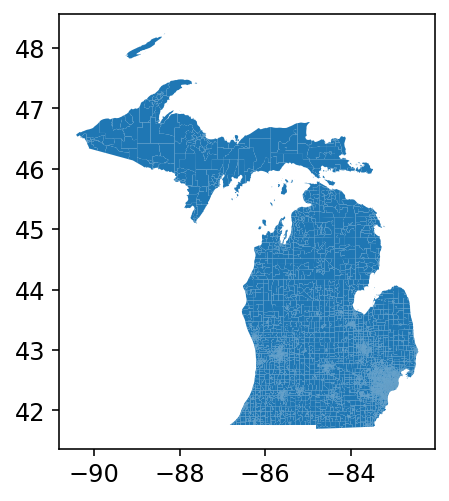

In [5]:
block.plot()

In [28]:

print(len(block.GEOID.iloc[0]))
print(len(block.TRACTCE.iloc[0]))

12
6


In [35]:
len(str(int(call.block_id.iloc[0])))

15

In [99]:
(call.block_id.iloc[1] == block.block_id).sum()

0

In [16]:
block.head()

NameError: name 'block' is not defined